In [949]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%precision 3


'%.3f'

In [950]:
pro = ts.pro_api('eb3245ab28b4190e85f8ee6b203f938ca144dde0d5048790c3723dac')


In [951]:
def SMA(df,  short_term_days, long_term_days):
    # sort by date
    df['trade_date'] = pd.to_datetime(df['trade_date']).dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df['trade_date'])
    df = df.sort_values(by='date')

    # short term
    SMA_short = pd.DataFrame()
    SMA_short['close'] = df['close'].rolling(window=short_term_days).mean()
    SMA_short

    # long term
    SMA_long = pd.DataFrame()
    SMA_long['close'] = df['close'].rolling(window=long_term_days).mean()
    SMA_long

    data = pd.DataFrame()
    data['trade_date'] = df['trade_date']
    data['close'] = df['close']
    data['SMA_short'] = SMA_short['close']
    data['SMA_long'] = SMA_long['close']

    data['date'] = pd.to_datetime(df['trade_date'])

    data.set_index(['date'], inplace=True)

    return data


In [952]:
# Double SMA Crossing Strategy
def buy_sell(data):
    sig_price_buy = []
    sig_price_sell = []
    flag = -1

    for i in range(len(data)):
        if data['SMA_short'][i] > data['SMA_long'][i]:
            if flag != 1:
                sig_price_buy.append(data['close'][i])
                sig_price_sell.append(np.nan)
                flag = 1
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)
        elif data['SMA_short'][i] < data['SMA_long'][i]:
            if flag != 0:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(data['close'][i])
                flag = 0
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)
        else:
            sig_price_buy.append(np.nan)
            sig_price_sell.append(np.nan)
    return (sig_price_buy, sig_price_sell)


In [953]:
# date and buy_sell signal
def dates(data):
    buy_dates = pd.DataFrame(data.loc[data['buy_signal_price'] > 0])
    sell_dates = pd.DataFrame(data.loc[data['sell_signal_price'] > 0])
    buy_dates.drop(columns=['sell_signal_price',
                            'SMA_short', 'SMA_long'], inplace=True)
    sell_dates.drop(columns=['buy_signal_price',
                             'SMA_short', 'SMA_long'], inplace=True)

    dates = pd.concat([buy_dates, sell_dates], sort=True)
    dates.sort_values(by='trade_date', inplace=True, ascending=False)
    dates.drop(
        columns=['close'], inplace=True)

    return dates


In [954]:
# drawing
def graph(data, code, short_term_days, long_term_days):
    ab = plt.figure(figsize=[40, 12])

    plt.plot(data['close'], label='PMAC', alpha=0.35)
    plt.plot(data['SMA_short'], label='SMA_' + str(short_term_days), alpha=0.7)
    plt.plot(data['SMA_long'], label='SMA_' + str(long_term_days), alpha=0.7)
    plt.scatter(data.index, data['buy_signal_price'],
                label='Buy', marker='^', color='green')
    plt.scatter(data.index, data['sell_signal_price'],
                label='Sell', marker='v', color='red')

    plt.title('{} close price hsitory buy and cell signals'.format(code))
    plt.xlabel(
        '{} - {}'.format(data['trade_date'].iloc[-1],  data['trade_date'].iloc[0]))
    plt.ylabel('Close price RMB')
    plt.legend()
    plt.show()


In [955]:
def earnings_buy_sell_same_shares_when_signal_shown(buy_sell_dates, shares):
    earnings = 0

    for i in range(len(buy_sell_dates)):
        if np.isnan(buy_sell_dates['buy_signal_price'][i]):
            earnings += buy_sell_dates['sell_signal_price'][i] * shares

        if np.isnan(buy_sell_dates['sell_signal_price'][i]):
            earnings -= buy_sell_dates['buy_signal_price'][i] * shares

    # df[(~(df['buy_signal_price'].isnull())) |
    #     (~(df['sell_signal_price'].isnull()))]

    print('earnings: ' + str(earnings / 100) + '%')


In [956]:
def graph_chart(stock_data, code, short_term_days, long_term_days):
    data = SMA(stock_data, short_term_days, long_term_days)
    buy_sell_data = buy_sell(data)
    data['buy_signal_price'] = buy_sell_data[0]
    data['sell_signal_price'] = buy_sell_data[1]

    graph(data, code, short_term_days, long_term_days)

    buy_sell_dates = dates(data)
    print('short_term_days: ' + str(short_term_days),
          'long_term_days: ' + str(long_term_days))
    return earnings_buy_sell_same_shares_when_signal_shown(buy_sell_dates, 100)


In [957]:
def get_earnings_percent(df, ts_code, name):
    print(name + ' ' + ts_code)
    # 5日、10日、20日、30日、60日、120日、250日
    graph_chart(df, ts_code, 5, 30)
    graph_chart(df, ts_code, 20, 60)
    graph_chart(df, ts_code, 30, 120)
    graph_chart(df, ts_code, 60, 250)


In [958]:
# https://tushare.pro/document/2?doc_id=25
# https://tushare.pro/document/2?doc_id=27

data = pro.stock_basic(list_status='L',
                       fields='ts_code,symbol,name,area,industry,list_date')

start_date = '201211001'
end_date = '20221010'

宁德时代 300750.SZ


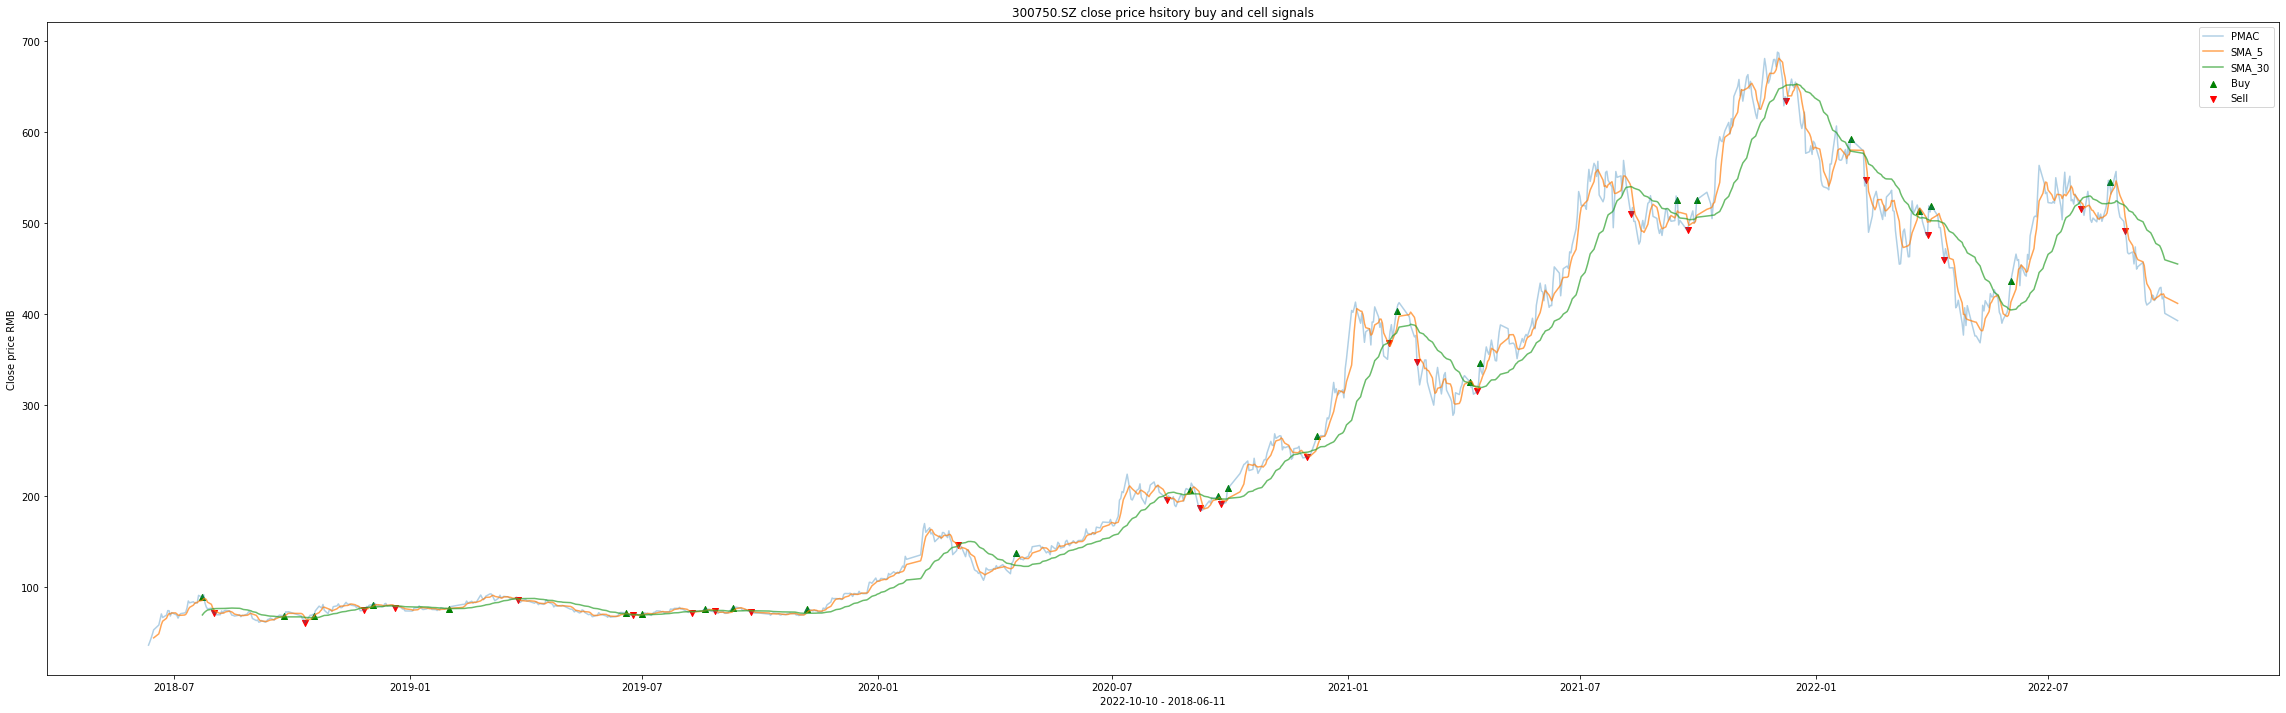

short_term_days: 5 long_term_days: 30
earnings: 280.4900000000001%


short_term_days: 20 long_term_days: 60
earnings: 320.71%


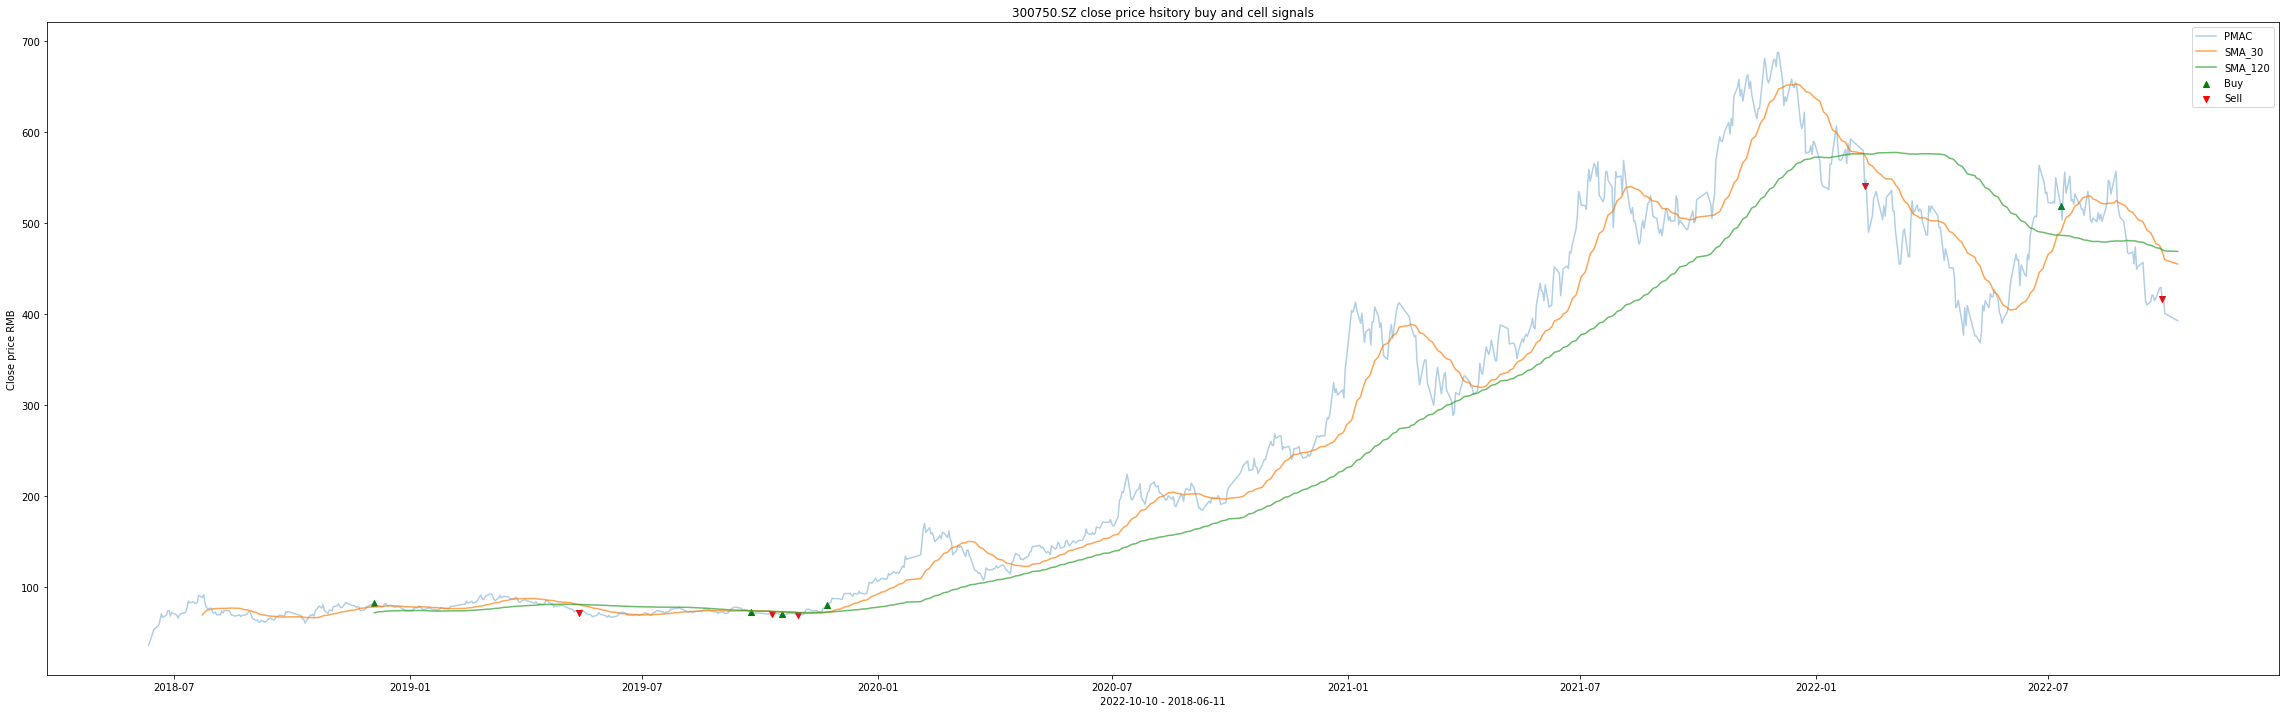

short_term_days: 30 long_term_days: 120
earnings: 345.54%


short_term_days: 60 long_term_days: 250
earnings: 344.67%


In [959]:
# Lithium Battery　リチウム電池
ts_code = '300750.SZ'
name = '宁德时代'
df = pro.daily(ts_code=ts_code,
               start_date=start_date, end_date=end_date).drop(columns=[
                   'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

get_earnings_percent(df, ts_code, name)


贵州茅台 600519.SH


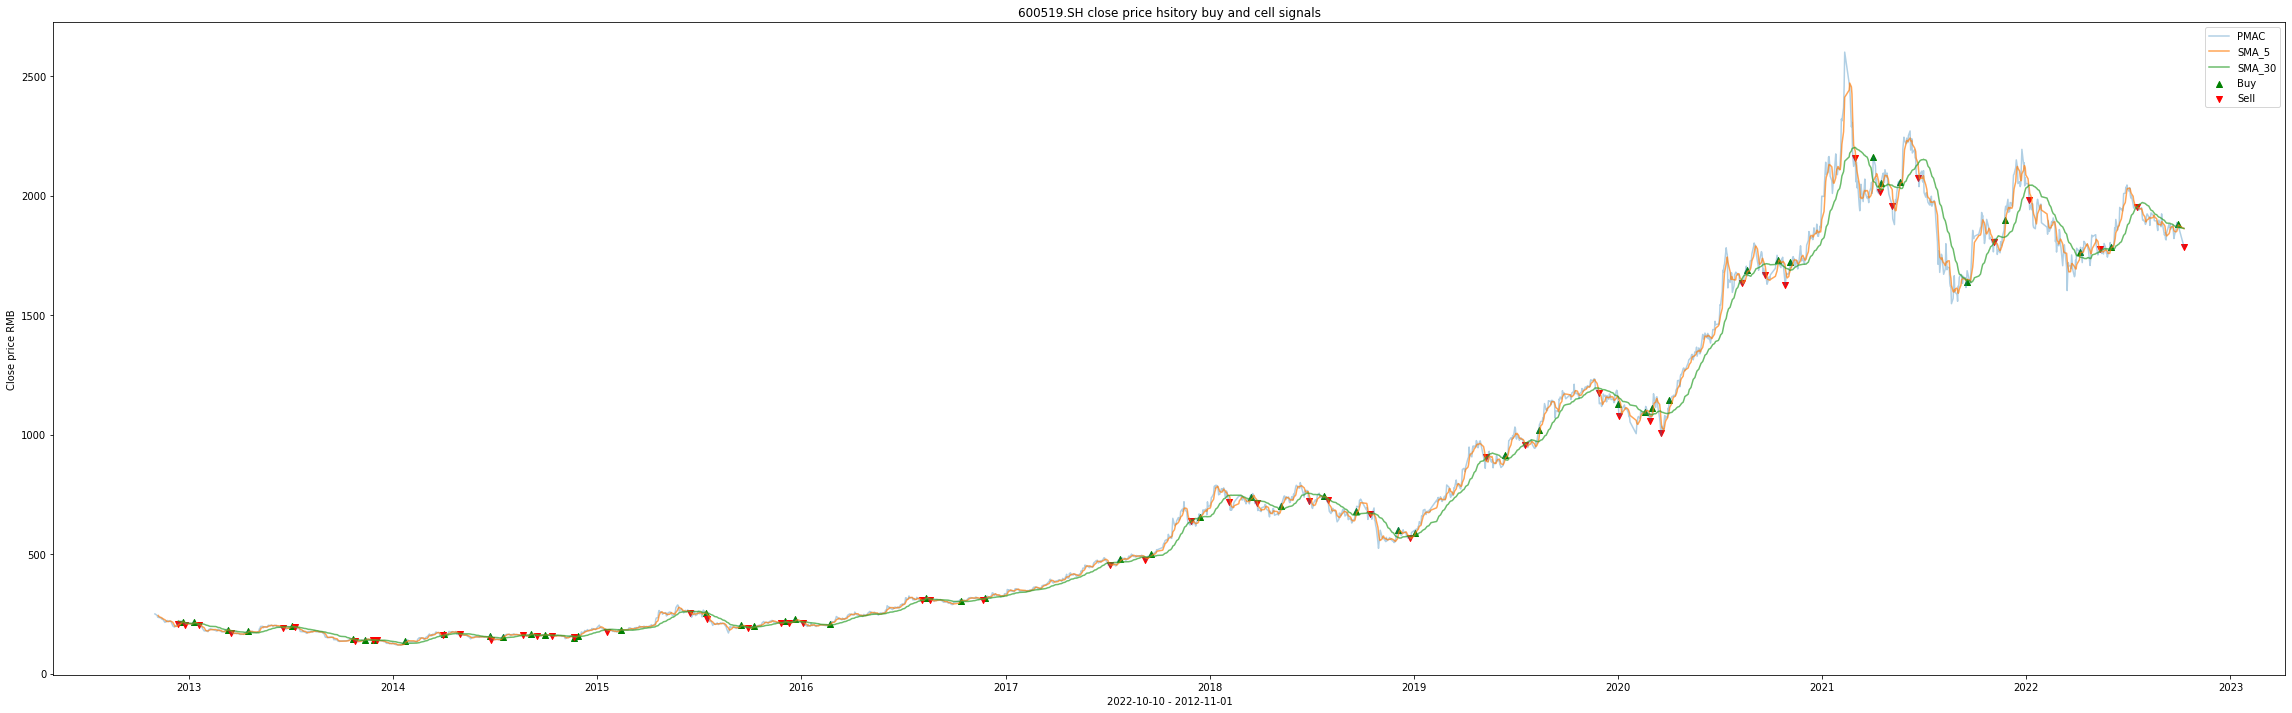

short_term_days: 5 long_term_days: 30
earnings: 1822.9899999999998%


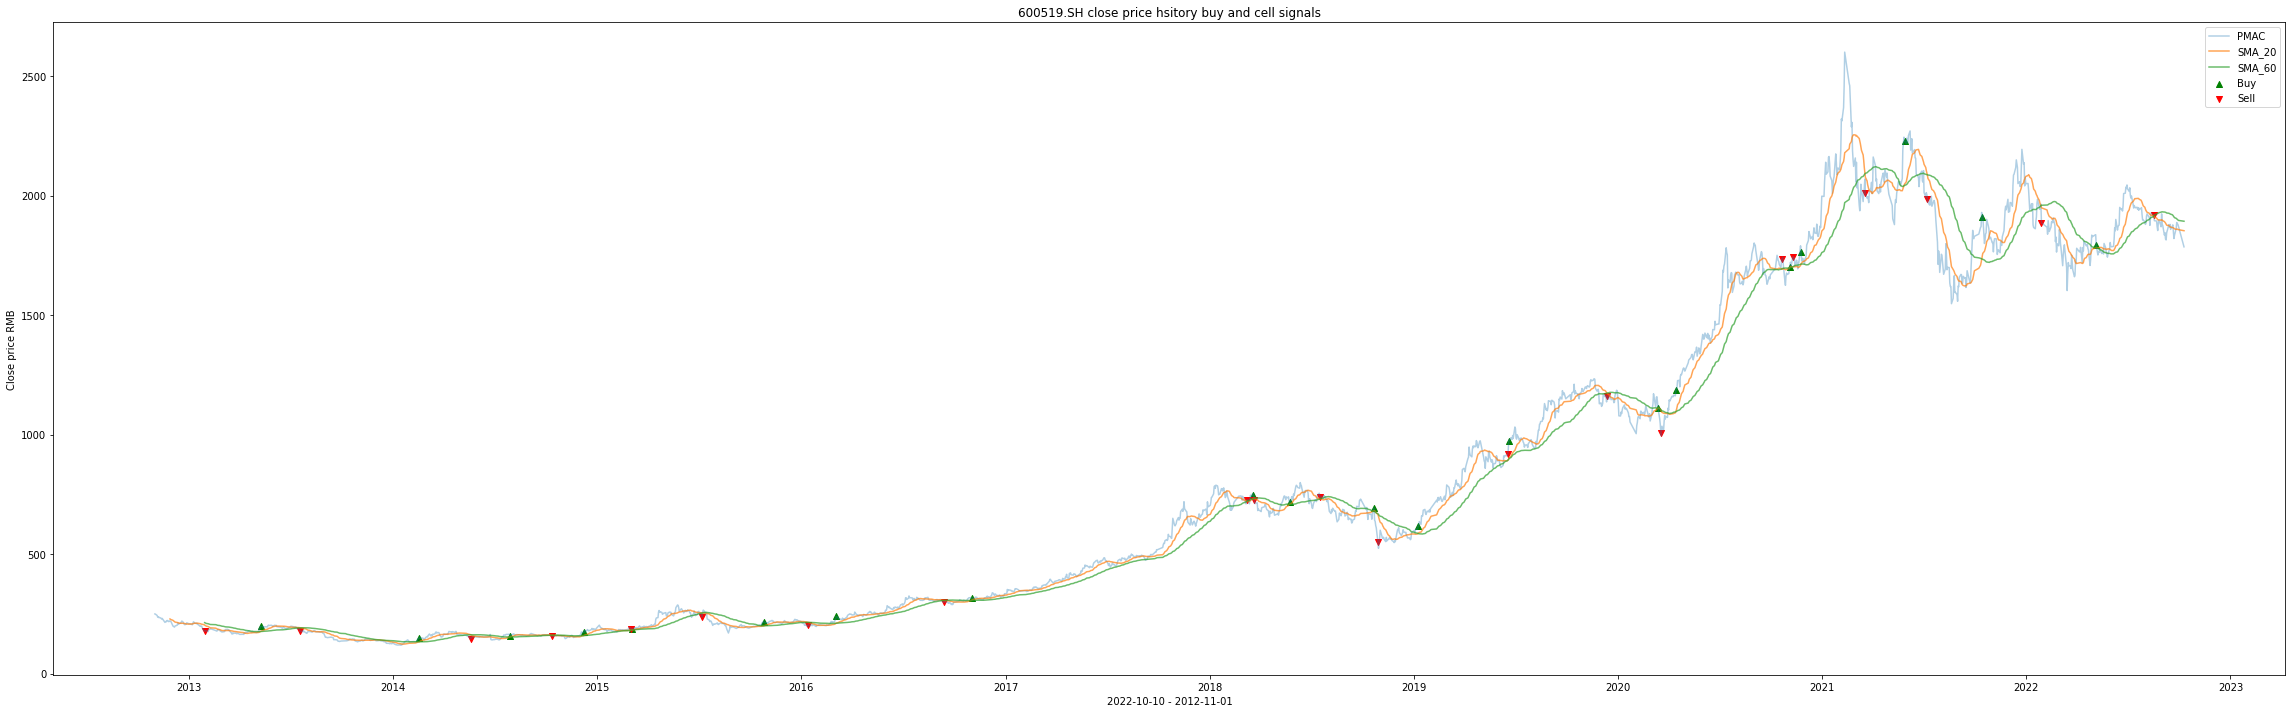

short_term_days: 20 long_term_days: 60
earnings: 1613.32%


short_term_days: 30 long_term_days: 120
earnings: 1320.39%


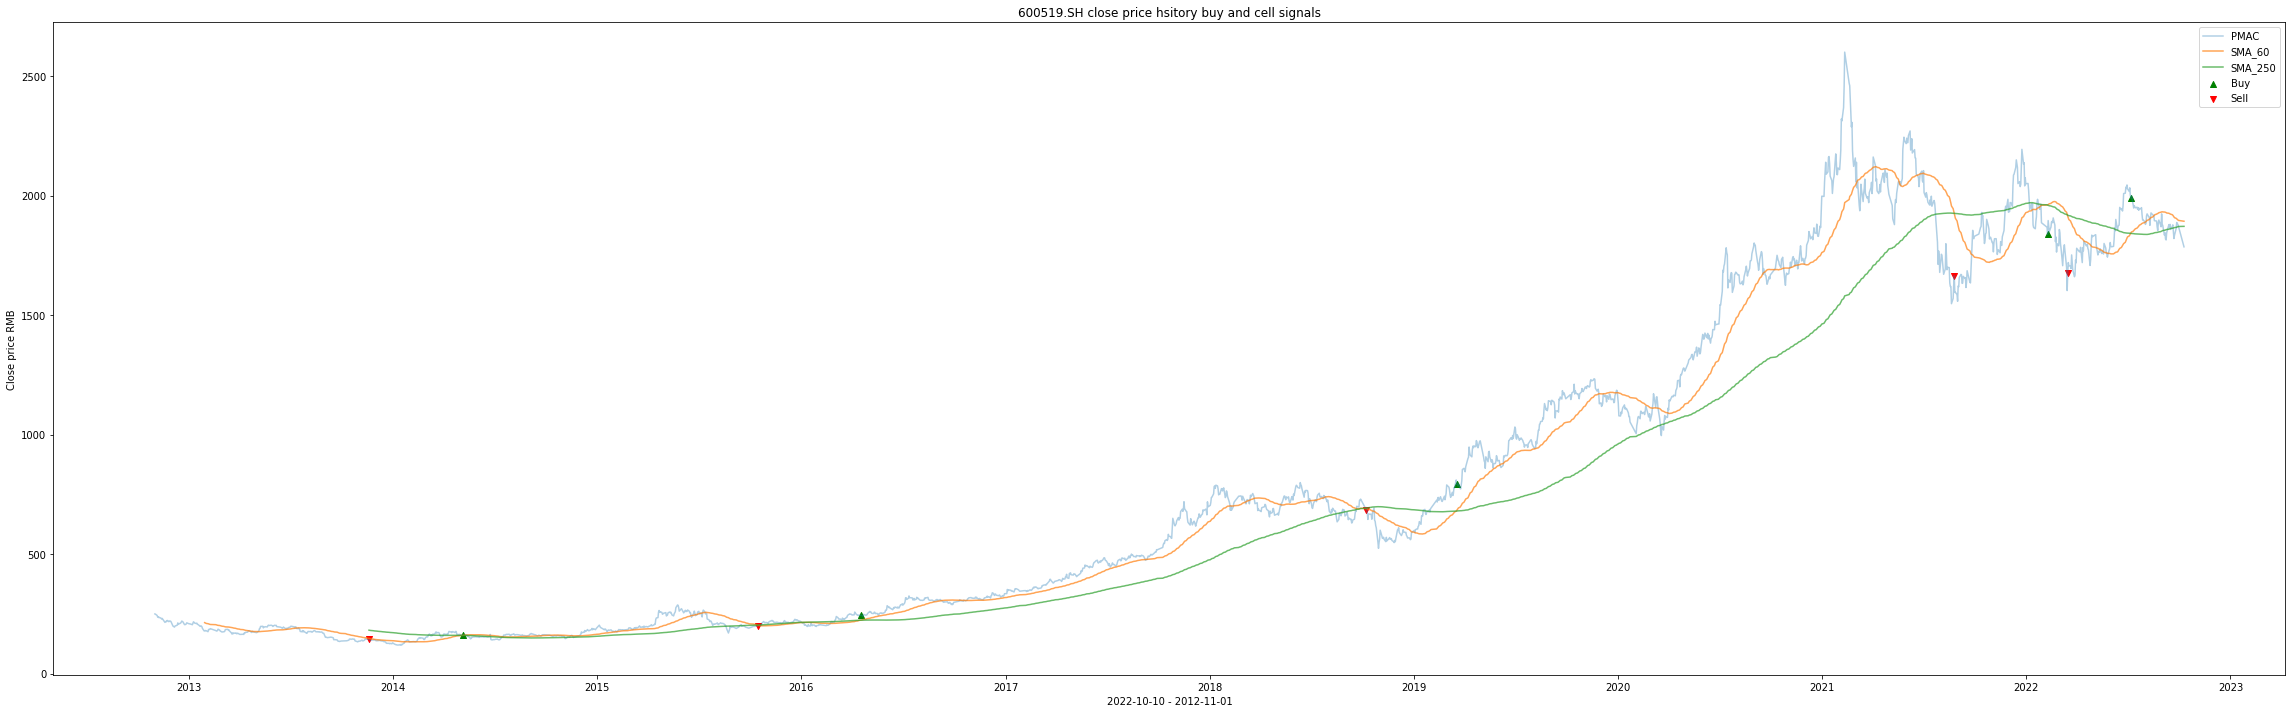

short_term_days: 60 long_term_days: 250
earnings: -656.27%


In [960]:
# Wine 酒
ts_code = '600519.SH'
name = '贵州茅台'
df = pro.daily(ts_code=ts_code,
               start_date=start_date, end_date=end_date).drop(columns=[
                   'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

get_earnings_percent(df, ts_code, name)

韦尔股份 603501.SH


short_term_days: 5 long_term_days: 30
earnings: 101.90999999999997%


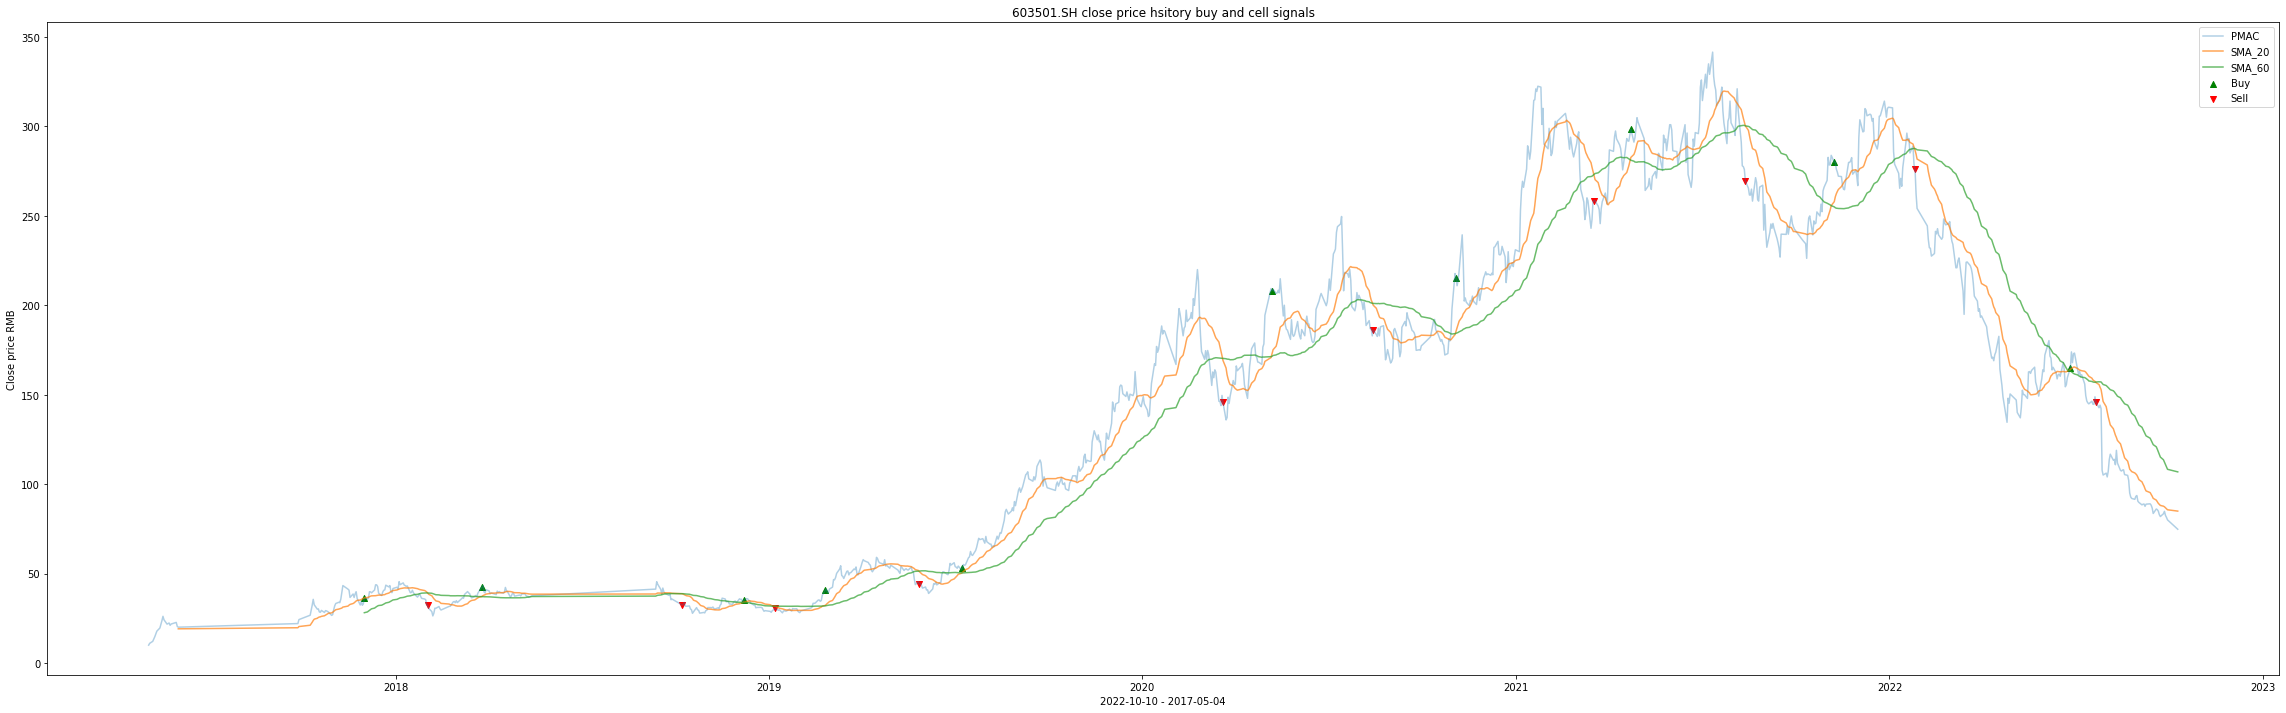

short_term_days: 20 long_term_days: 60
earnings: 46.79999999999996%


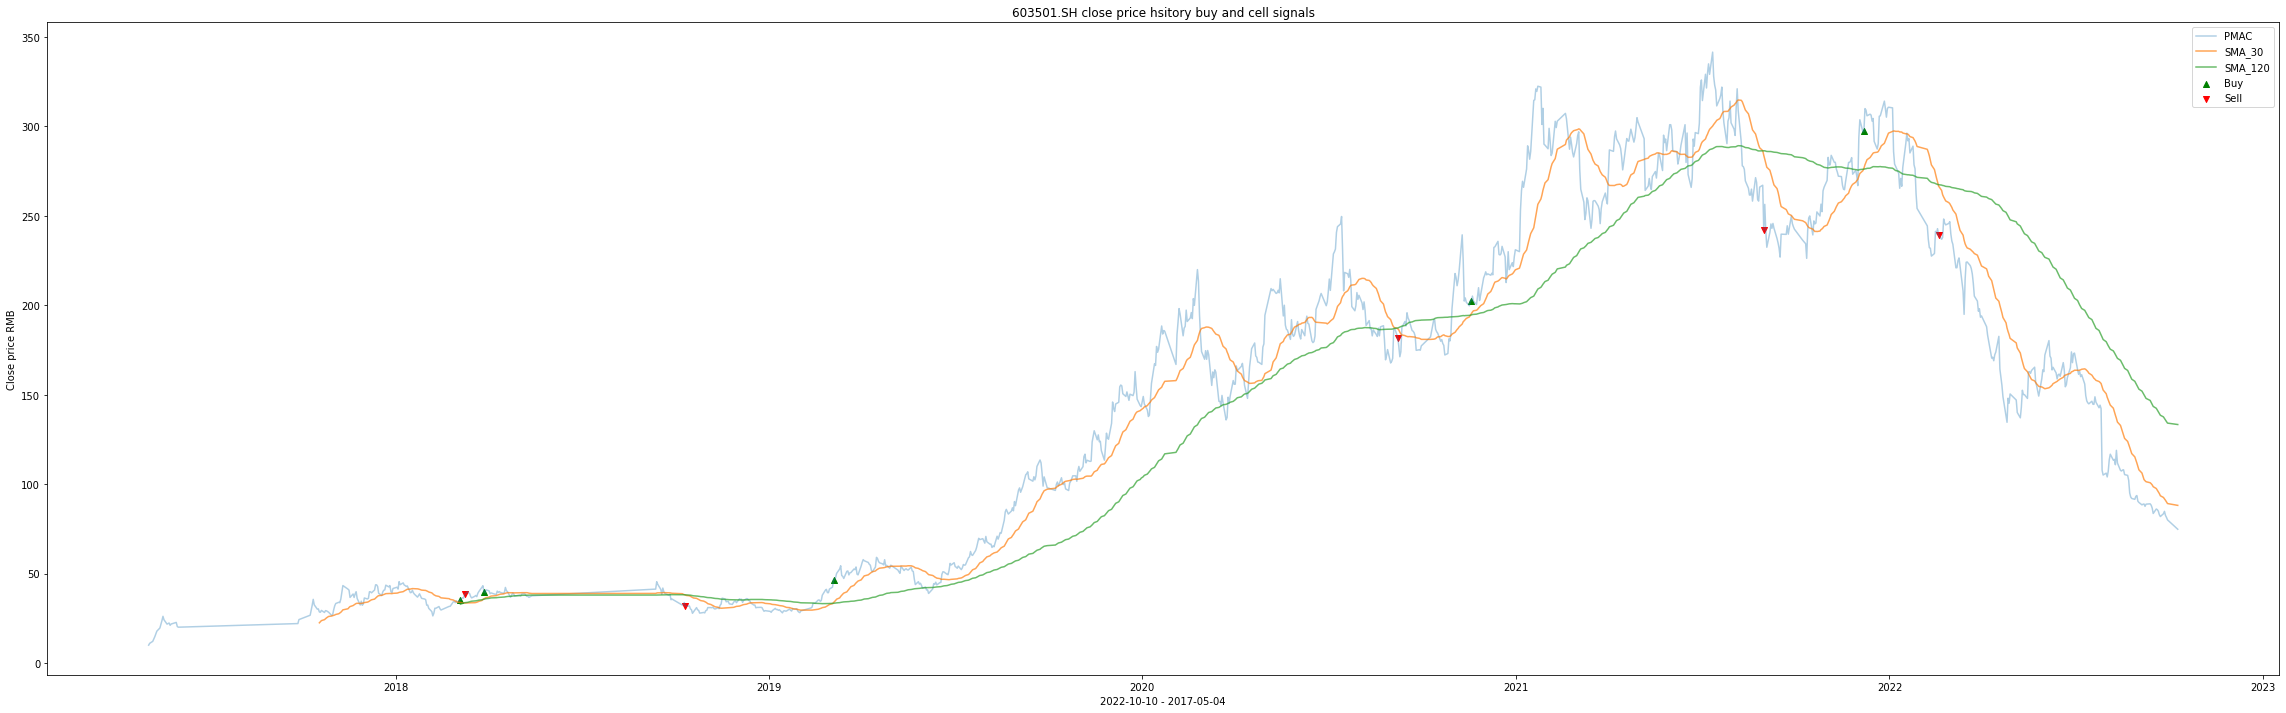

short_term_days: 30 long_term_days: 120
earnings: 111.85%


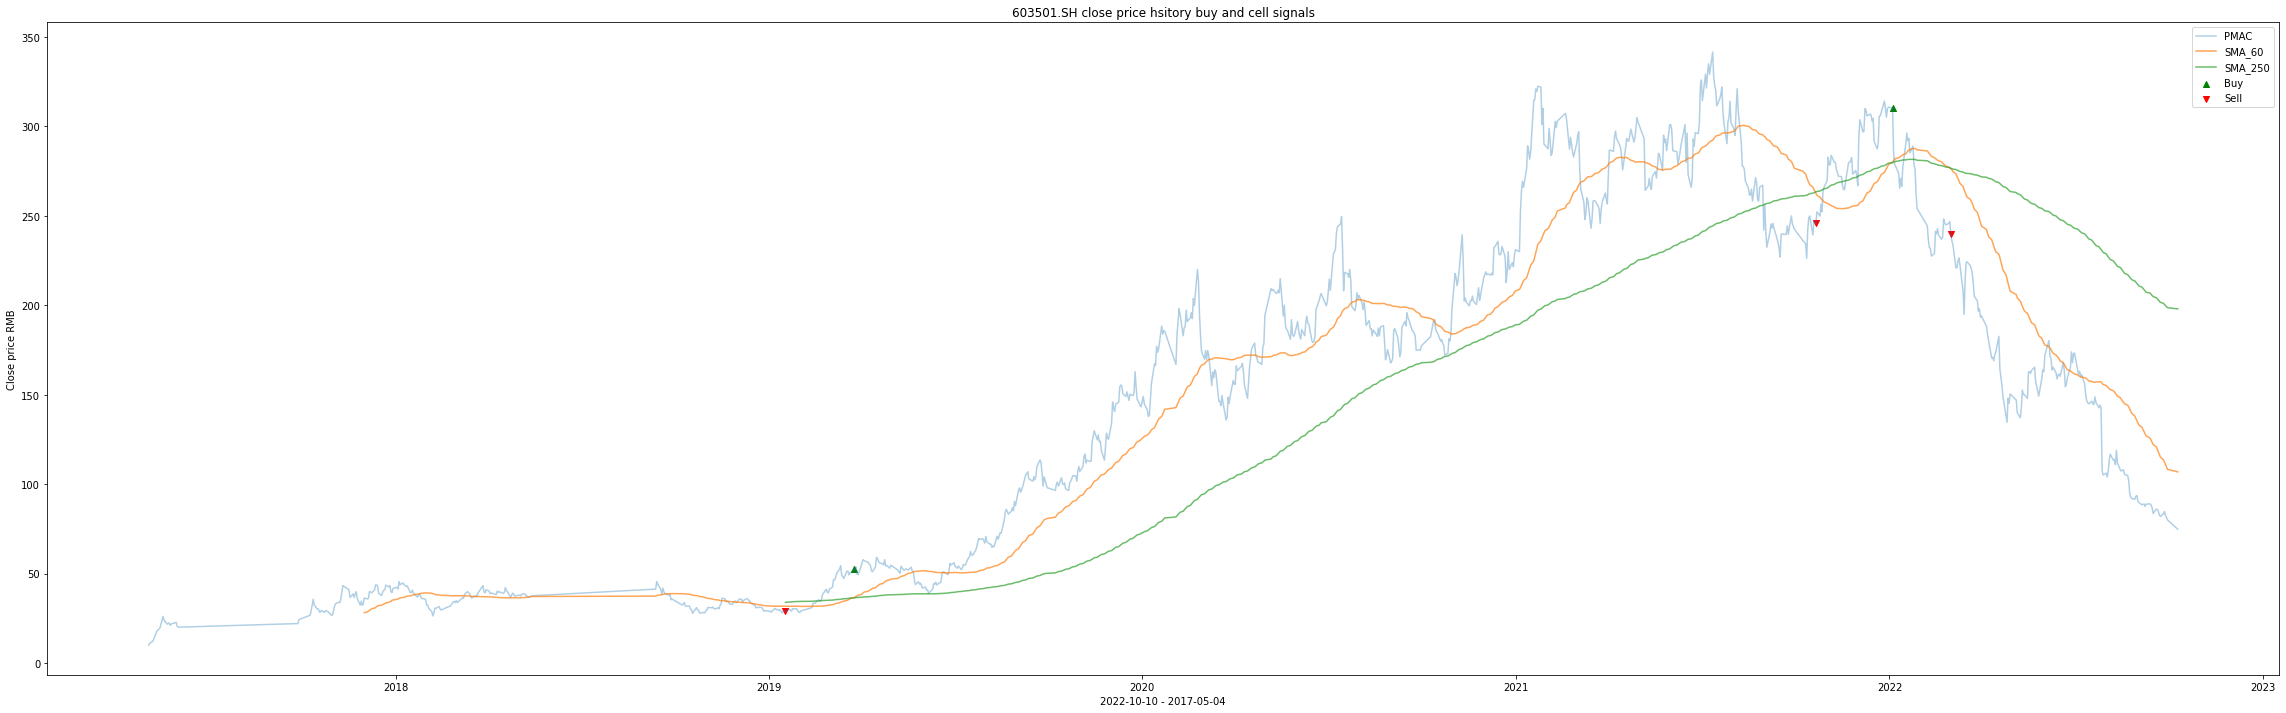

short_term_days: 60 long_term_days: 250
earnings: 152.03%


In [961]:
# Semiconductors 半導体
ts_code = '603501.SH'
name = '韦尔股份'
df = pro.daily(ts_code=ts_code,
               start_date=start_date, end_date=end_date).drop(columns=[
                   'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

get_earnings_percent(df, ts_code, name)

In [962]:
# Pharmaceutical 医薬
ts_code = '603259.SH'
name = '药明康德'
df = pro.daily(ts_code=ts_code,
               start_date=start_date, end_date=end_date).drop(columns=[
                   'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

get_earnings_percent(df, ts_code, name)

药明康德 603259.SH


short_term_days: 5 long_term_days: 30
earnings: -71.34%


short_term_days: 20 long_term_days: 60
earnings: -108.89999999999996%


short_term_days: 30 long_term_days: 120
earnings: 64.69%


short_term_days: 60 long_term_days: 250
earnings: 27.82%


芒果超媒 300413.SZ


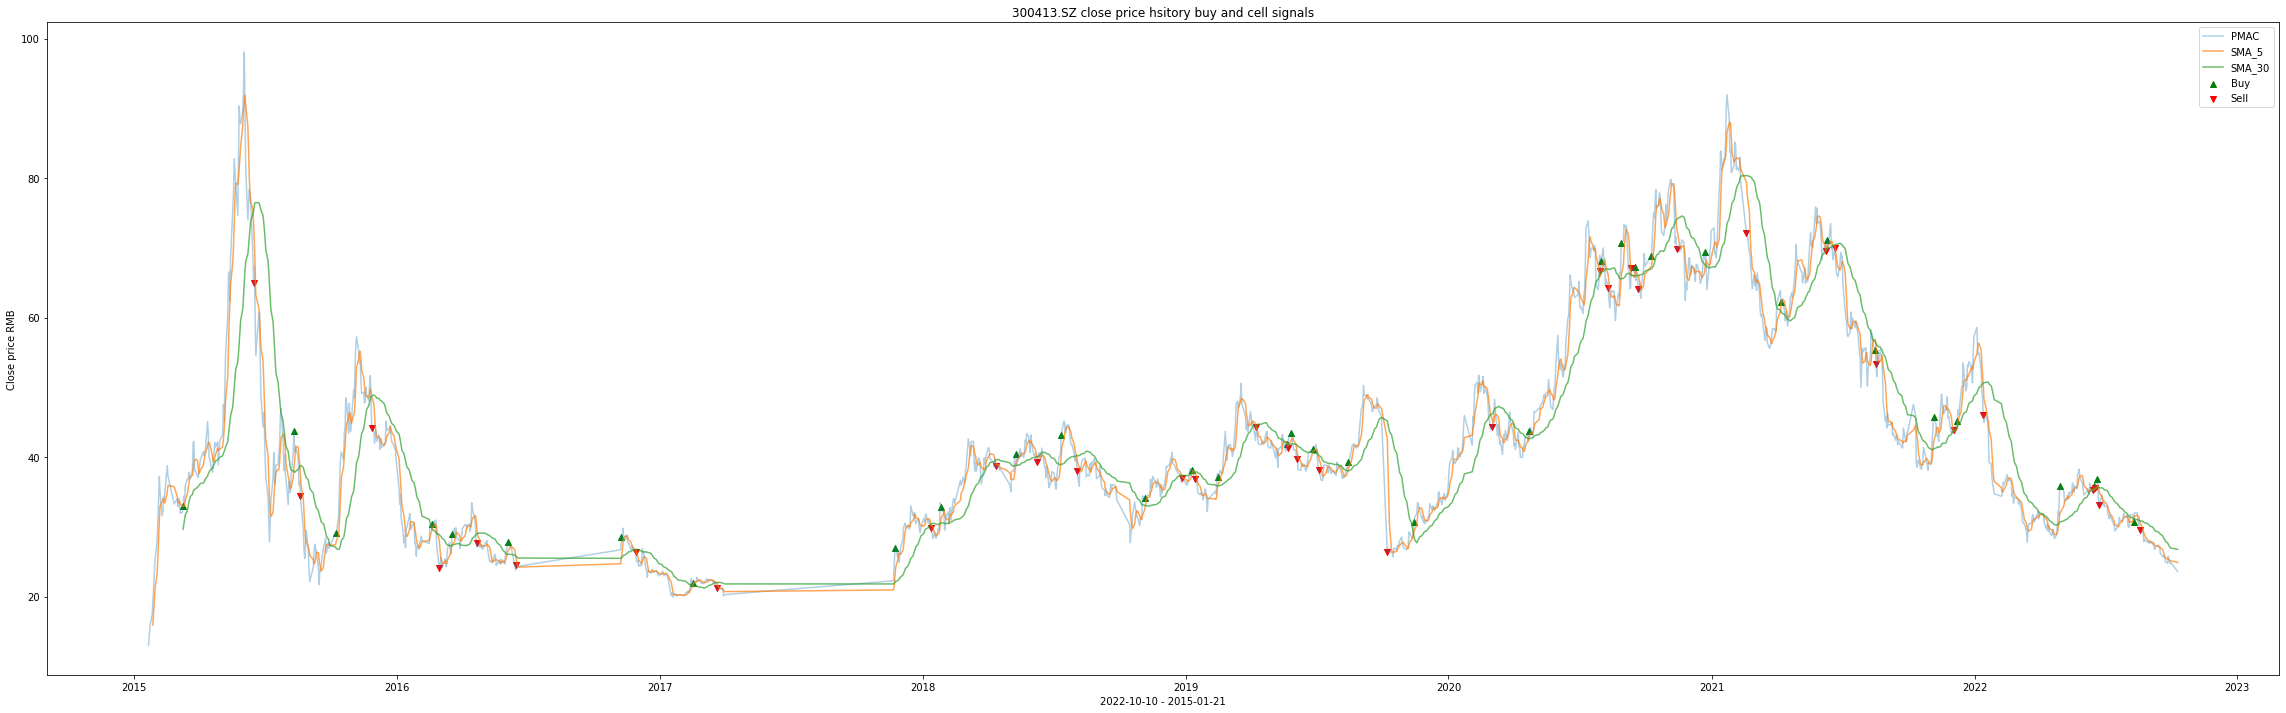

short_term_days: 5 long_term_days: 30
earnings: 42.079999999999984%


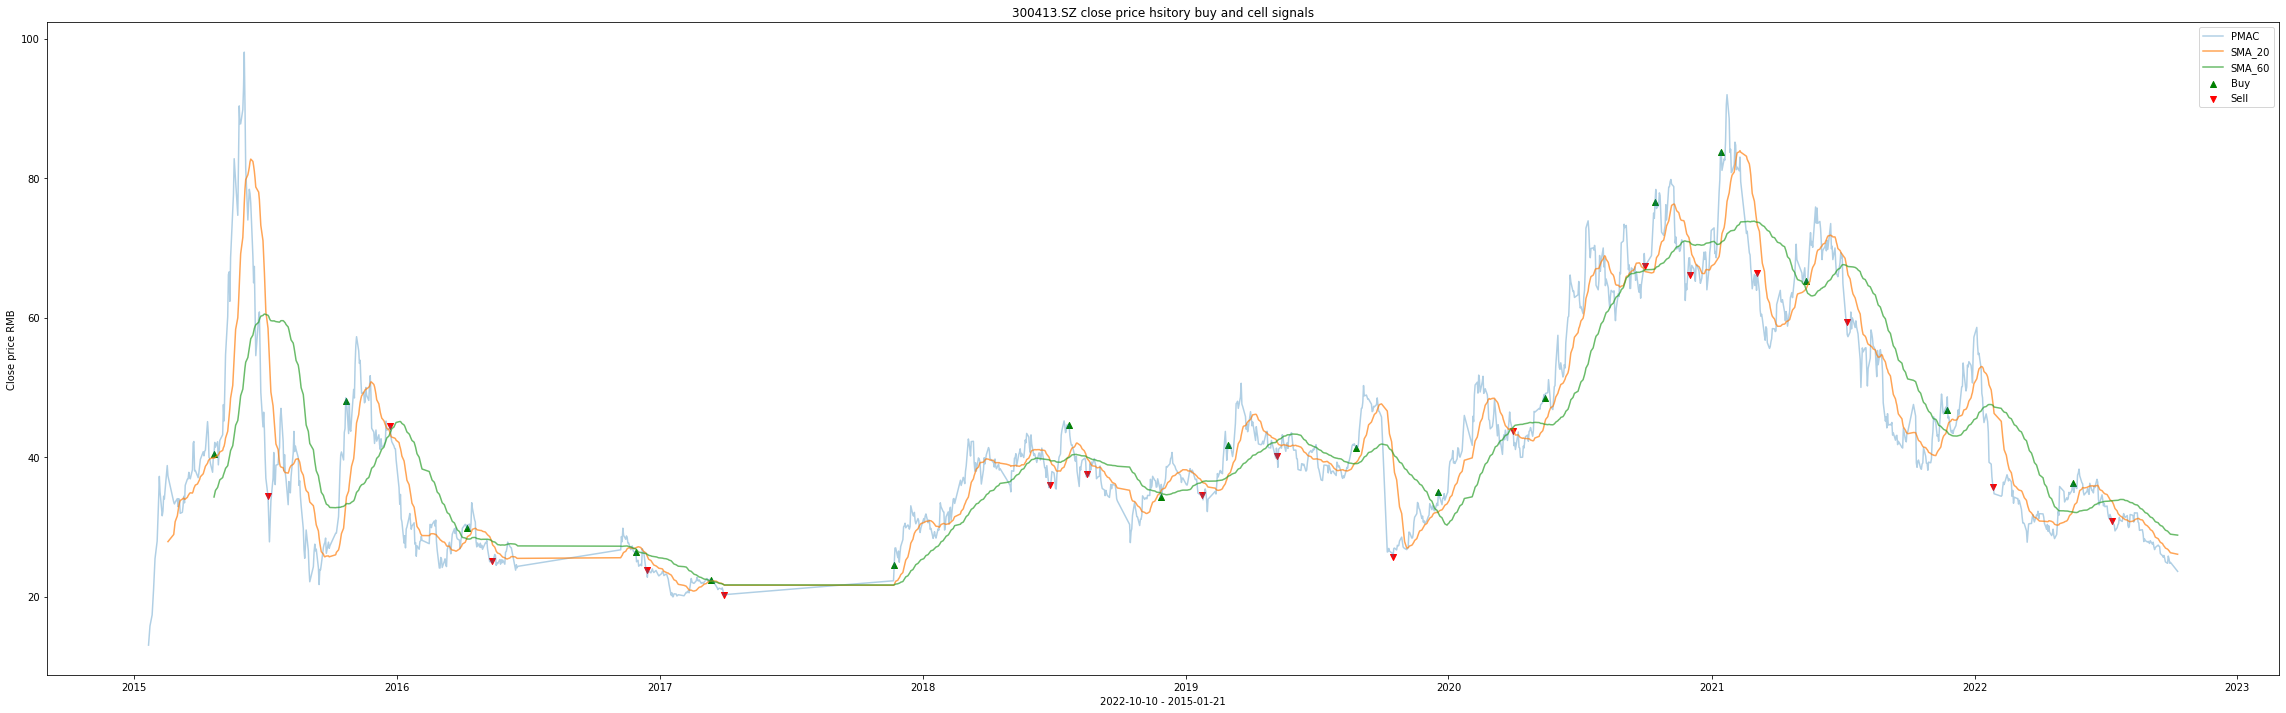

short_term_days: 20 long_term_days: 60
earnings: -53.77999999999998%


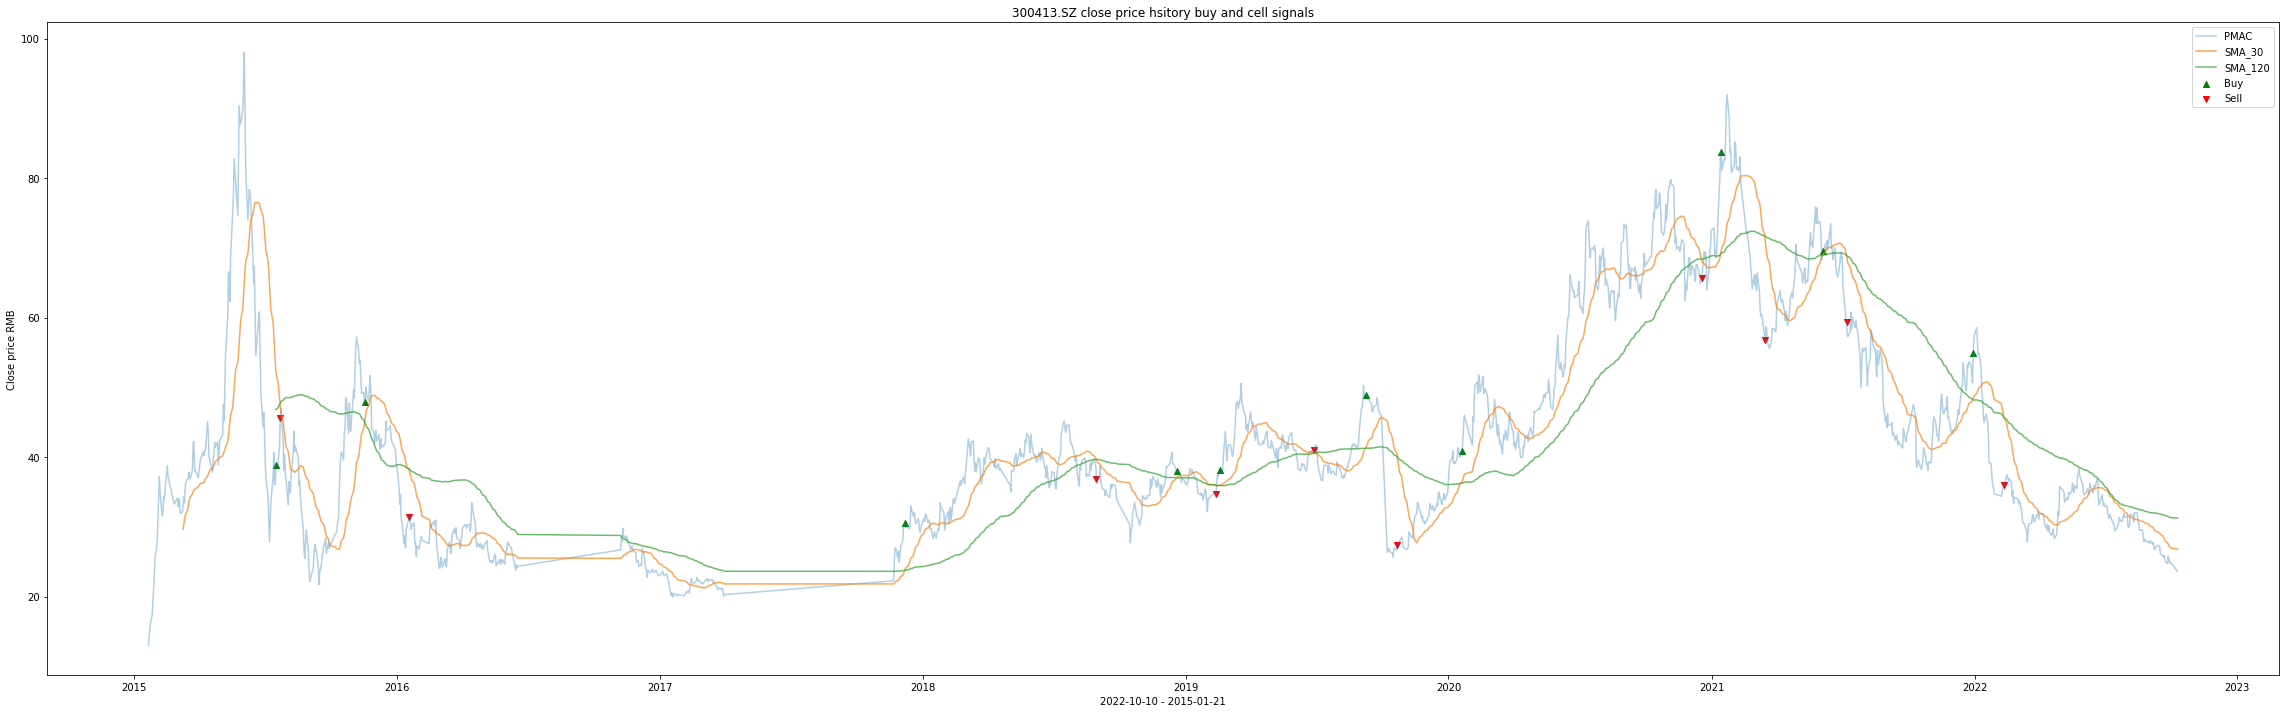

short_term_days: 30 long_term_days: 120
earnings: -56.76%


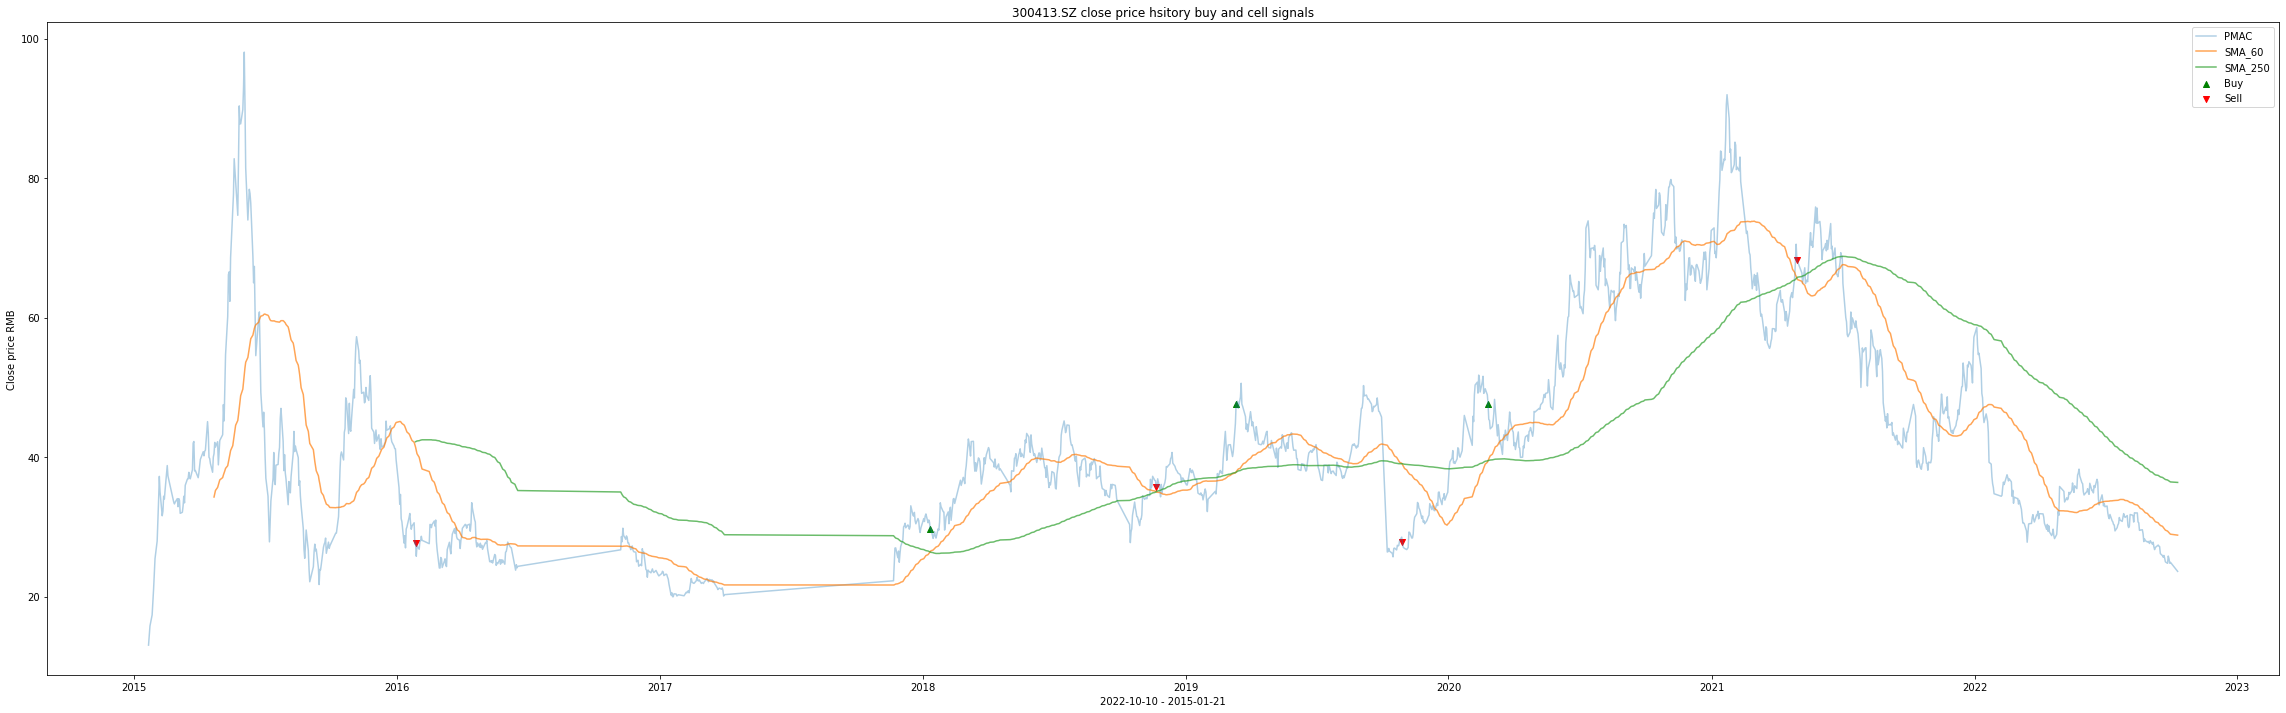

short_term_days: 60 long_term_days: 250
earnings: 34.71000000000001%


In [963]:
# New media
ts_code = '300413.SZ'
name = '芒果超媒'
df = pro.daily(ts_code=ts_code,
               start_date=start_date, end_date=end_date).drop(columns=[
                   'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

get_earnings_percent(df, ts_code, name)

通威股份 600438.SH


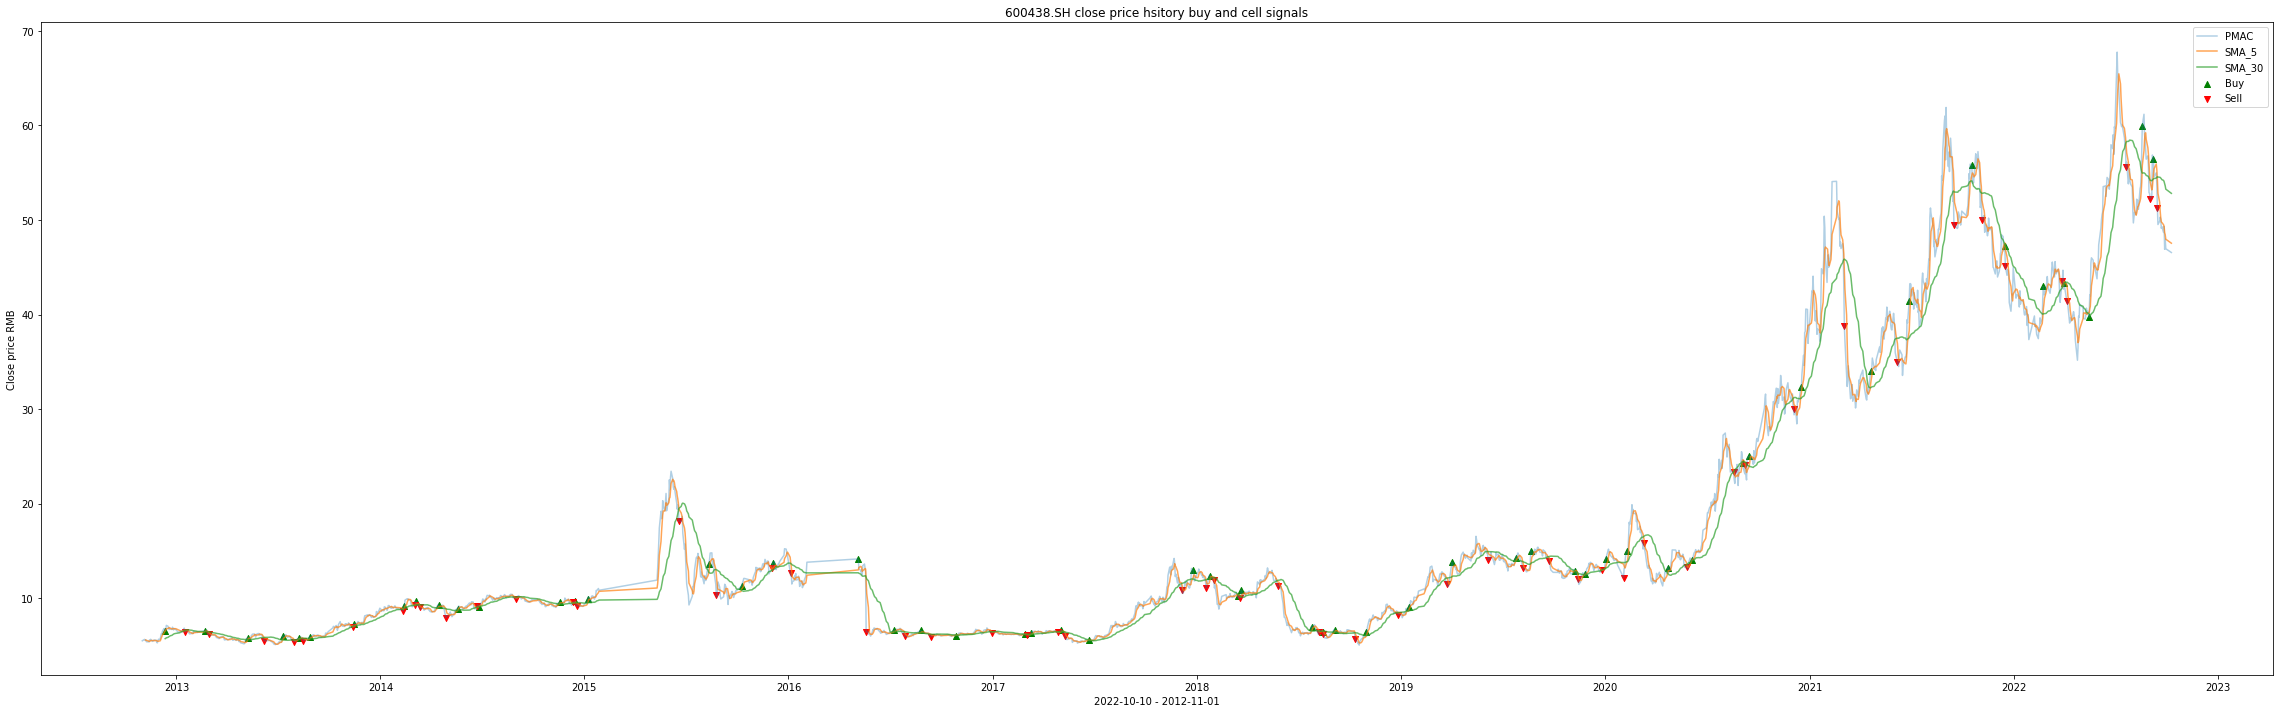

short_term_days: 5 long_term_days: 30
earnings: 21.95%


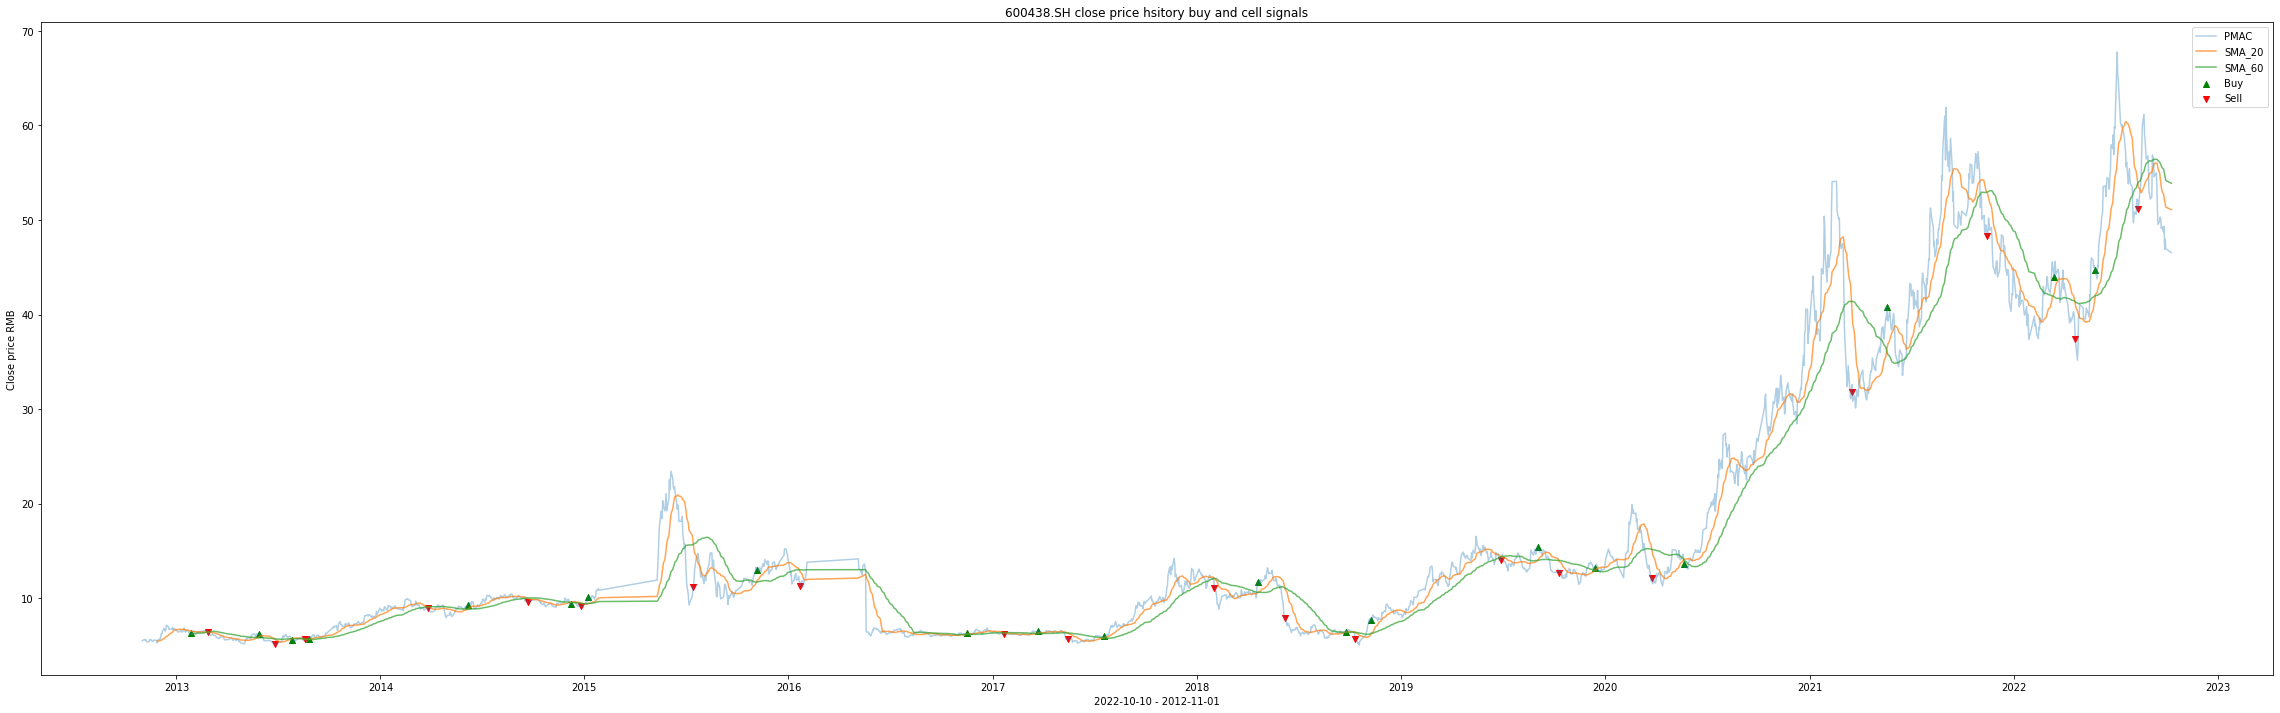

short_term_days: 20 long_term_days: 60
earnings: 29.63%


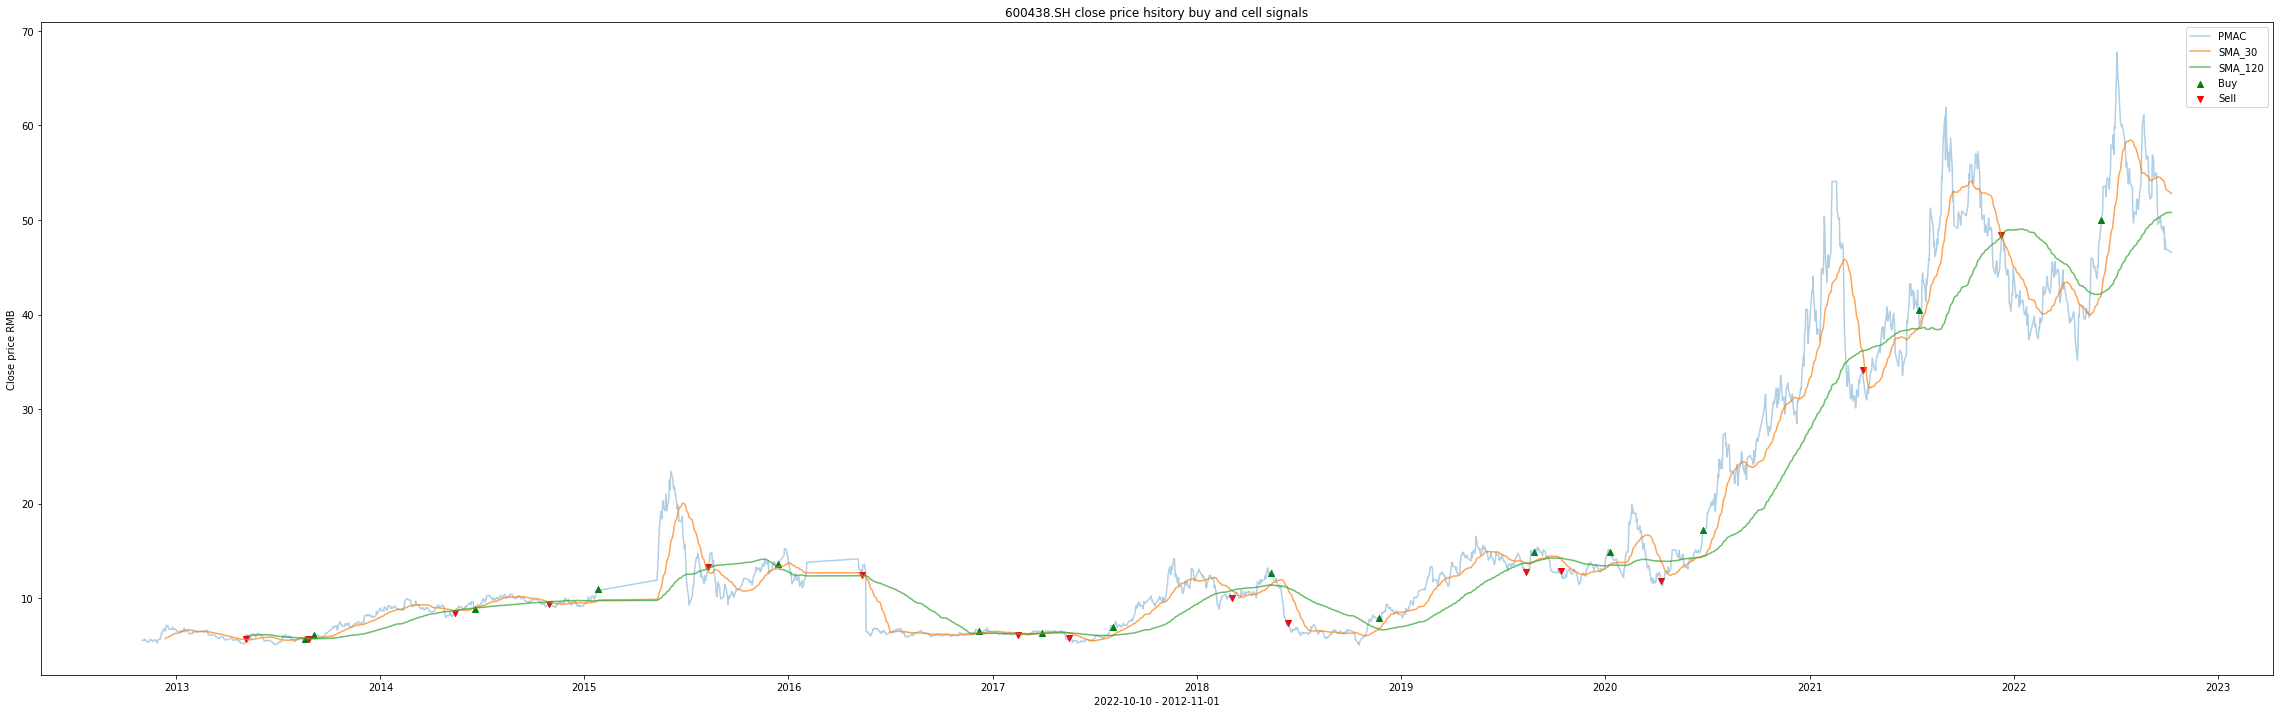

short_term_days: 30 long_term_days: 120
earnings: -18.829999999999995%


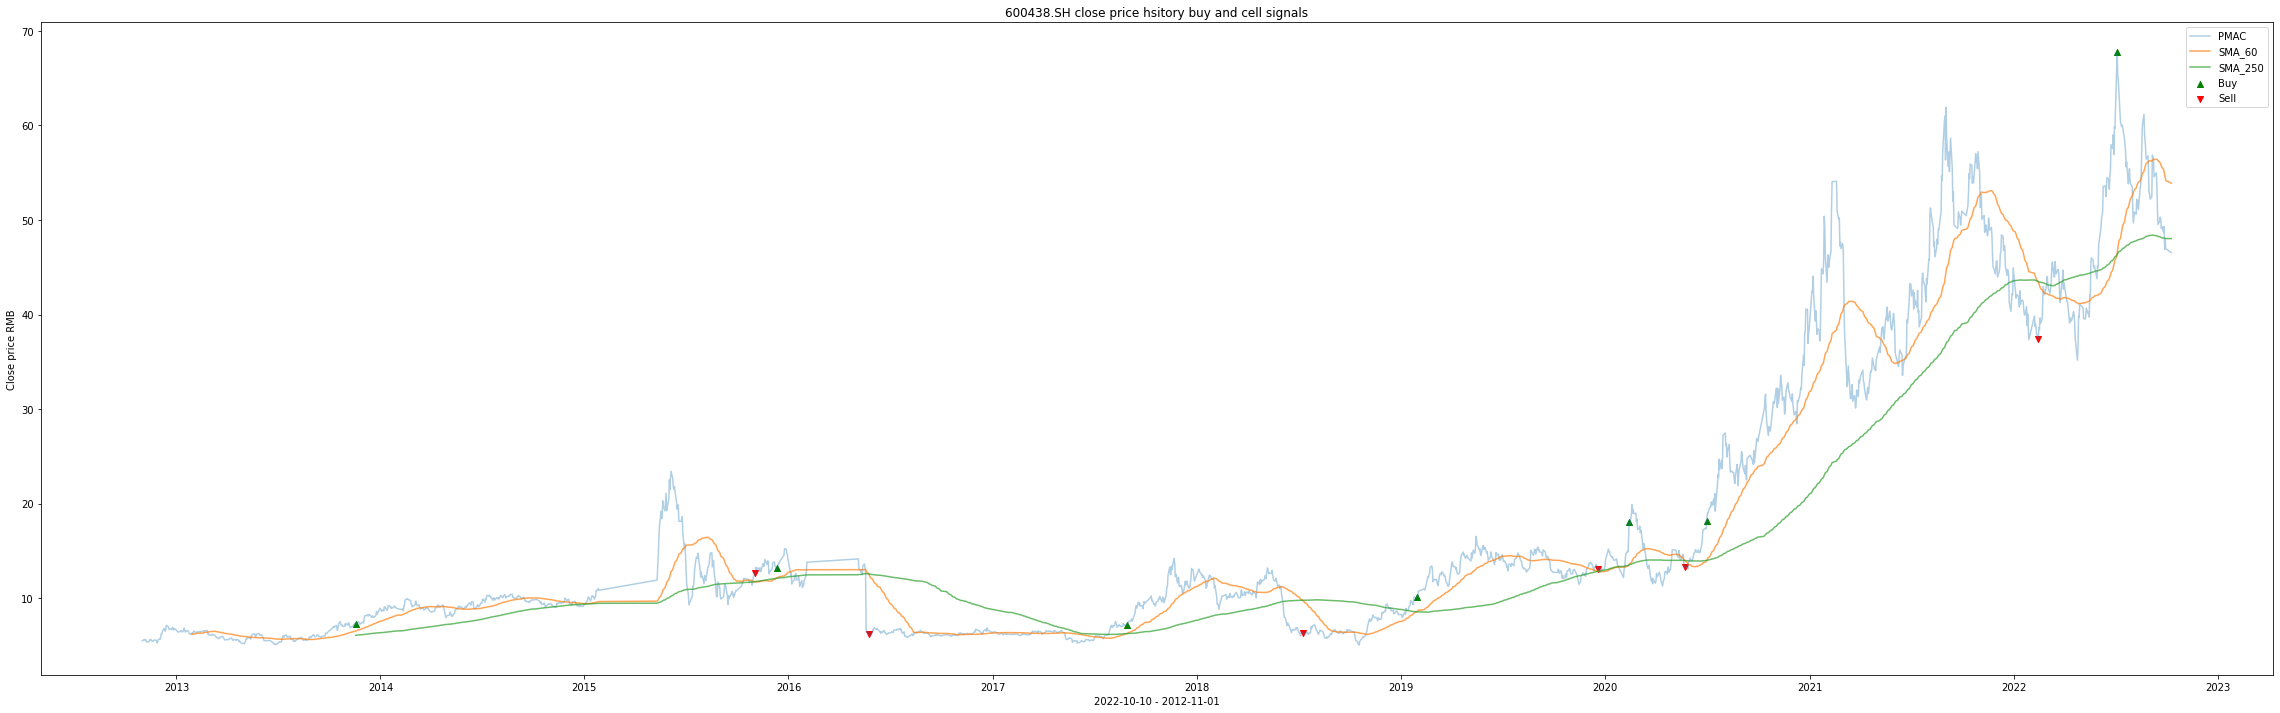

short_term_days: 60 long_term_days: 250
earnings: -52.72%


In [964]:
# Photovoltaic 太陽光発電
ts_code = '600438.SH'
name = '通威股份'
df = pro.daily(ts_code=ts_code,
               start_date=start_date, end_date=end_date).drop(columns=[
                   'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

get_earnings_percent(df, ts_code, name)

In [965]:
# # Model: Logistic regression analysis

# def set_pre_stock_data(stock_data, days_ago, end_date):
#   length = len(stock_data)
#   df = pro.trade_cal(exchange='', start_date='20020830', end_date='20220830')

#   stock_data["pre_open"] = pre_stock_data["open"]
#   stock_data["pre_high"] = pre_stock_data["high"]
#   stock_data["pre_low"] = pre_stock_data["low"]
#   stock_data["pre_vol"] = pre_stock_data["vol"]
#   stock_data["pre_amount"] = pre_stock_data["amount"]


# pre_stock_data = pro.daily(
#     ts_code='600000.SH', start_date=start_date, end_date=end_date)
# print(pre_stock_data.head())

# # 予測変数:is_up
# stock_data.groupby("change").size()
# stock_data["is_up"] = stock_data["change"].map(lambda x: 1 if x > 0 else 0)
# stock_data.groupby("is_up").size()


# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split

# # 説明変数
# X = stock_data[["pre_open", "pre_high", "pre_low", "pre_close", "pre_vol", "pre_amount"]]

# Y = stock_data["is_up"]
# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

# # TODO:random forest / SVM
# model = LogisticRegression()
# clf = model.fit(X_train, y_train)

# print("train result:", clf.score(X_train, y_train))
# print("test result:", clf.score(X_test, y_test))

# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)

# clf = model.fit(X_train_std, y_train)
# print("train:", clf.score(X_train_std, y_train))
# print("test:", clf.score(X_test_std, y_test))

# # 偏回帰係数
# print(clf.coef_)
# # 0.5303701 is pre_high

# # Calculate the exponential of all elements in the input array.
# print(np.exp(clf.coef_))
